# Data Used in this Project

In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2024-08-13


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

# custom modules
import lib.figs_funcs as fun_plot
import lib.funcs_general as funcs_general
import lib.processingdata_funcs as processingdata_funcs

%load_ext autoreload
%autoreload 2


matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
sns.set(style="white")



# Initial information

In [3]:
# to save or not all the informations computed here (df with LogNorm, PsiNorm, MB and PST)
saving = False

In [4]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [5]:
# genes of OUR dataset
genes_relevant = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes


In [6]:
# Genes Classification using the reference of Carbognin paper and its signature (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# genes in genes_relevant that are not in the three groups
other = [x for x in genes_relevant if x not in naive and x not in formative_early and x not in formative_late]
other

['Gbx2', 'Pou5f1', 'Sall4', 'Tcf7l1']

In [7]:
# time steps for the 10X scRNA-seq data
time=["00h", "06h", "12h", "24h", "48h"]

# load the index of the different time steps
time_sep = np.loadtxt(path_data+"GE_data/time_sep.txt").astype(np.int32)


# Bulk data 

In [8]:
# Bulk data from Martello Lab
file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name)
# Set the column "Symbol" as index
df_bulk_all.set_index("Symbol", inplace=True)
# Remove the name "Symbol" from the index
df_bulk_all.index.name = None
# Remove the EnsemblGeneID column
df_bulk_all.drop(columns=["EnsemblGeneID"], inplace=True)
df_bulk_all.head(3)

,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726


In [9]:
# Split column names to identify groups
column_groups = df_bulk_all.columns.str.rsplit('_', n=1).str[0]
unique_groups = column_groups.unique()

# Average columns within each group
averaged_columns = {group: df_bulk_all.filter(regex=group+'_\d$').mean(axis=1) for group in unique_groups}
# create a similar object for the standard deviation of the mean of each group
std_columns = {group: df_bulk_all.filter(regex=group+'_\d$').std(axis=1)/np.sqrt(2) for group in unique_groups}

# Convert the dictionary back to a DataFrame
df_bulk_averaged = pd.DataFrame(averaged_columns)
df_bulk_averaged = df_bulk_averaged.reindex(genes_relevant)
# df_bulk_averagd.head()

df_bulk_std = pd.DataFrame(std_columns)
df_bulk_std = df_bulk_std.reindex(genes_relevant)


In [10]:
data_zscore = zscore(df_bulk_averaged, axis=1)
data_zscore = data_zscore.reindex(genes_relevant)

data_zscore_2iL = data_zscore.loc[:, data_zscore.columns.str.contains("2iL")]
data_zscore_2i = data_zscore.loc[:, data_zscore.columns.str.contains("2i") & ~data_zscore.columns.str.contains("2iL")]

# Estrazione delle ore 
column_names_2iL = ['GM_2iL', 'GM_24h_2iL', 'GM_36h_2iL', 'GM_48h_2iL', 'GM_60h_2iL',
                    'GM_72h_2iL', 'GM_84h_2iL', 'GM_96h_2iL']
column_names_2i = ['GM_2i', 'GM_12h_2i', 'GM_24h_2i', 'GM_36h_2i', 'GM_48h_2i', 
                   'GM_60h_2i', 'GM_72h_2i', 'GM_84h_2i']

hours_2iL = pd.Series(column_names_2iL).str.extract(r'_(\d+h)?_2iL')[0].fillna('0h')
hours_2i = pd.Series(column_names_2i).str.extract(r'_(\d+h)?_2i')[0].fillna('0h')


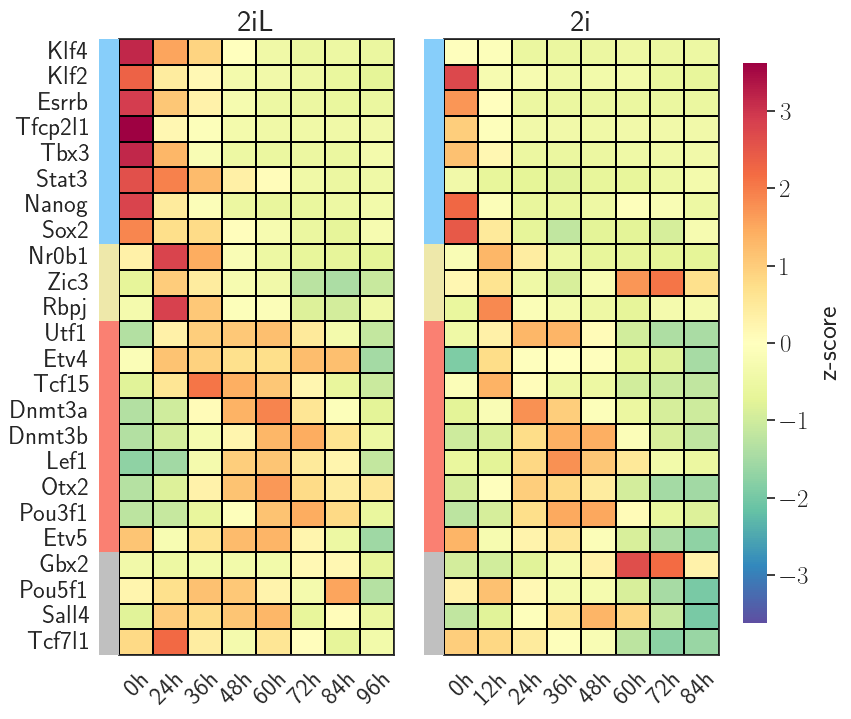

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), 
                        gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1}, 
                        sharey=True)

vmin = -max(abs(data_zscore).max())
vmax = max(abs(data_zscore).max())
cmap = 'Spectral_r'

# Heatmap for "2iL"
sns.heatmap(data_zscore_2iL, ax=axs[0], cmap=cmap, yticklabels=df_bulk_averaged.index,
            vmin=vmin, vmax=vmax, linewidths=0.05, linecolor='black')
axs[0].set_title('2iL', fontsize=22)
axs[0].set_xticks(np.arange(len(hours_2iL)) + 1)  # Centra gli xticks rispetto alle colonne
axs[0].set_xticklabels(hours_2iL, rotation=45, ha="right")
axs[0].tick_params(labelsize=18)

# Heatmap for "2i"
sns.heatmap(data_zscore_2i, ax=axs[1], cmap=cmap, yticklabels=False,
            vmin=vmin, vmax=vmax, linewidths=0.05, linecolor='black')
axs[1].set_title('2i', fontsize=22)
axs[1].set_xticks(np.arange(len(hours_2i)) + 1)  # Centra gli xticks rispetto alle colonne
axs[1].set_xticklabels(hours_2i, rotation=45, ha="right")
axs[1].tick_params(labelsize=18)

for ax in axs:
    ax.collections[0].colorbar.remove()

cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7]) # Aggiustare le dimensioni se necessario
cbar = fig.colorbar(axs[1].collections[0], cax=cbar_ax, label='z-score')
cbar.ax.yaxis.label.set_fontsize(20)
cbar.ax.tick_params(labelsize=18)

cbar.outline.set_visible(False)

axs[0].set_ylabel('')


for ax in axs:
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)


genes_relevant = df_bulk_averaged.index.tolist()
colors = {
    'naive': 'lightskyblue',
    'formative_early': 'palegoldenrod',
    'formative_late': 'salmon',
    'other': 'silver'  
}

groups = {
    'naive': naive,
    'formative_early': formative_early,
    'formative_late': formative_late,
    'other': other 
}

for i in range(2):
    divider = make_axes_locatable(axs[i])
    line_ax = divider.append_axes("left", size=0.2, pad=0, sharey=axs[i])
    
    line_ax.set_xlim(0, 1)
    line_ax.set_ylim(axs[i].get_ylim())
    line_ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    line_ax.spines['left'].set_visible(False)
    line_ax.spines['right'].set_visible(False)
    line_ax.spines['top'].set_visible(False)
    line_ax.spines['bottom'].set_visible(False)
    
    for group, gene_list in groups.items():
        for gene in gene_list:
            gene_idx = genes_relevant.index(gene)
            line_ax.axhspan(gene_idx, gene_idx + 1, color=colors[group], linewidth=0)

axs[0].set_yticks(np.arange(len(genes_relevant))+0.5)
axs[0].set_yticklabels(genes_relevant, fontsize=18)
# axs[1].set_yticks(np.arange(len(genes_relevant)))  # Se vuoi yticklabels anche sul secondo plot
axs[0].tick_params(axis='y', pad=15)


fig_folder_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG'
if not os.path.exists(fig_folder_path):
    os.makedirs(fig_folder_path)
fig.savefig(os.path.join(fig_folder_path, 'heatmap_bulk_2i_2iL.svg'), format='svg', bbox_inches='tight')


In [12]:
fig_folder_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG'
if not os.path.exists(fig_folder_path):
    os.makedirs(fig_folder_path)

# Raw Data

In [13]:
# load raw data
df_raw_all = pd.read_csv(path_data + "GE_data/raw.csv", header=0, index_col=0, sep=",")
df_raw_all.index.name = None
df_raw_all.head()
print("shape of the raw data:", df_raw_all.shape)

# select just the Relevant genes (rows with index contained in genes_relevant)
df_raw = df_raw_all.loc[genes_relevant].reindex(genes_relevant)

shape of the raw data: (13833, 9894)


# LogNorm Data

In [14]:
# load raw data
df_lN_all = pd.read_csv(path_data + "GE_data/logNorm.csv", header=0, index_col=0, sep=",")
df_lN_all.index.name = None
df_lN_all.head()
print("shape of the raw data:", df_lN_all.shape)

# select just the Relevant genes (rows with index contained in genes_relevant)
df_lN = df_lN_all.loc[genes_relevant].reindex(genes_relevant)

shape of the raw data: (13833, 9894)


## Fraction of zeros per gene

In [15]:
# # Calculate the fraction of zero values per gene
# zeros_perGene_frac = np.sum(df_lN == 0, axis=1) / df_lN.shape[1]

# plt.figure(figsize=(3, 10))
# s = sns.barplot(x=zeros_perGene_frac, y=df_lN.index, color='salmon')

# # thr_zero = 0.5
# # plt.axvline(x=thr_zero, color='r', linestyle='-', label=thr_zero)

# # plt.title('Fraction of zeros per gene', fontsize=32)
# s.set_xlabel('Fraction of zeros', fontsize=18)
# # plt.xticks([0,0.25,0.5,0.75,1],fontsize=25)
# s.set_xticks([])
# plt.yticks(fontsize=20)
# plt.grid()
# # print at the top of each bar the fraction of zeros
# for i in range(len(df_lN.index)):
#     plt.text(x=zeros_perGene_frac[i]+0.01, y=i-0.1, s=(str(round(zeros_perGene_frac[i], 2))), size=12)
# plt.show()


## Gene Expression in time

In [16]:
df_lN_ts_sep = processingdata_funcs.bulk_scRNA(df_lN, time_sep)
df_bulk_from_scRNA = pd.DataFrame([df_lN_ts_sep[0].mean(axis=1), df_lN_ts_sep[1].mean(axis=1), df_lN_ts_sep[2].mean(axis=1), df_lN_ts_sep[3].mean(axis=1), df_lN_ts_sep[4].mean(axis=1)]).T
data_zscore = zscore(df_bulk_from_scRNA, axis=1)



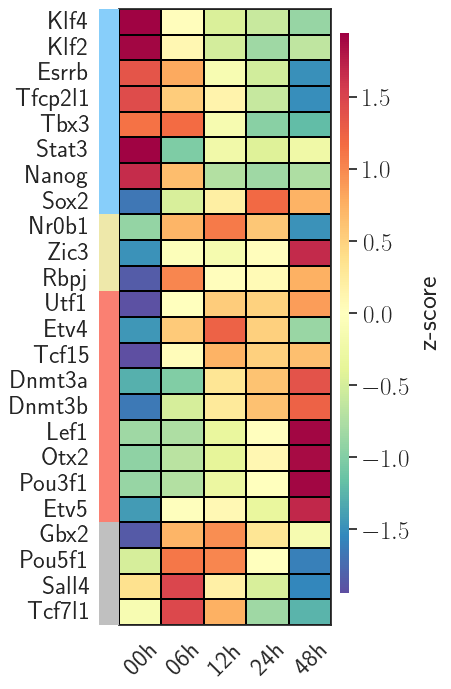

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8), 
                        gridspec_kw={'width_ratios': [1]}, 
                        sharey=True)

vmin = -max(abs(data_zscore).max())
vmax = max(abs(data_zscore).max())
cmap = 'Spectral_r'
hours_sc = ["00h", "06h", "12h", "24h", "48h"]

sns.heatmap(data_zscore, ax=ax, cmap=cmap, yticklabels=df_bulk_from_scRNA.index,
            vmin=vmin, vmax=vmax, linewidths=0.05, linecolor='black')
# ax.set_title('scRNA-seq LogNorm averaged by time points', fontsize=22)
ax.set_xticks(np.arange(len(hours_sc)) + 1)  
ax.set_xticklabels(hours_sc, rotation=45, ha="right")
ax.tick_params(labelsize=18)

ax.collections[0].colorbar.remove()

cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, label='z-score')
cbar.ax.yaxis.label.set_fontsize(20)
cbar.ax.tick_params(labelsize=18)

cbar.outline.set_visible(False)

ax.set_ylabel('')


ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)


genes_relevant = df_bulk_from_scRNA.index.tolist()
colors = {
    'naive': 'lightskyblue',
    'formative_early': 'palegoldenrod',
    'formative_late': 'salmon',
    'other': 'silver' 
}

groups = {
    'naive': naive,
    'formative_early': formative_early,
    'formative_late': formative_late,
    'other': other  
}


divider = make_axes_locatable(ax)
line_ax = divider.append_axes("left", size=0.2, pad=0, sharey=ax)

line_ax.set_xlim(0, 1)
line_ax.set_ylim(ax.get_ylim())
line_ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
line_ax.spines['left'].set_visible(False)
line_ax.spines['right'].set_visible(False)
line_ax.spines['top'].set_visible(False)
line_ax.spines['bottom'].set_visible(False)
    
for group, gene_list in groups.items():
    for gene in gene_list:
        gene_idx = genes_relevant.index(gene)
        line_ax.axhspan(gene_idx, gene_idx + 1, color=colors[group], linewidth=0)

ax.set_yticks(np.arange(len(genes_relevant))+0.5)
ax.set_yticklabels(genes_relevant, fontsize=18)
# axs[1].set_yticks(np.arange(len(genes_relevant)))  # Se vuoi yticklabels anche sul secondo plot
ax.tick_params(axis='y', pad=15)


# fig.savefig(os.path.join(fig_folder_path, 'heatmap_scRNAseq_averaged.svg'), format='svg', bbox_inches='tight')



## Pseudotime

Min pseudotime:  0.0 - Max pseudotime:  38.2221053912345
Number of cells in PST df:  9696


Text(0, 0.5, 'Density')

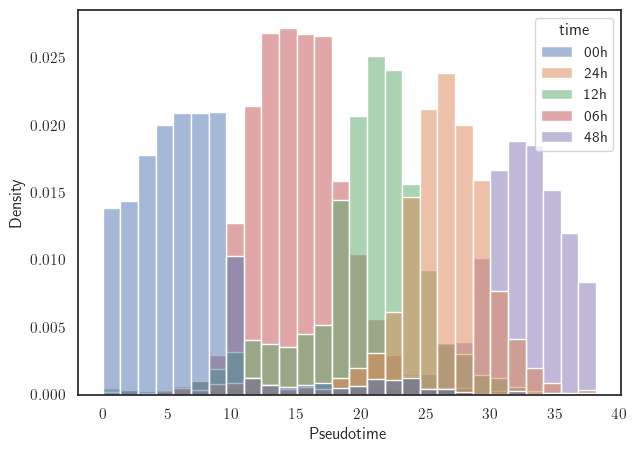

In [19]:
# Load PST Info dataframe: it links cell barcode to pseudotime
PST_df_lN = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt', 
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"]) # pst for LogNorm 

print("Min pseudotime: ", np.min(PST_df_lN["pst"]), "- Max pseudotime: ", np.max(PST_df_lN["pst"]))
print("Number of cells in PST df: ", PST_df_lN.shape[0])

# sorting in ascending values of pseudo-time
PST_df_lN = PST_df_lN.sort_values(by=['pst'])

# PLOT different times separated
plt.figure(figsize=(7,5))
sns.histplot(data=PST_df_lN, x="pst", hue="time", stat="density")
plt.xlabel("Pseudotime")
plt.ylabel("Density")


In [20]:
column_names = PST_df_lN["barcodes"]
df_lN_pst = df_lN.reindex(columns = column_names)

if saving:
    pd.DataFrame.to_csv(df_lN_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv") 

# to load
# pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")

In [21]:
# For all the genes
df_lN_all_pst = df_lN_all.reindex(columns = column_names)
df_lN_all_pst.shape
if saving:
    pd.DataFrame.to_csv(df_lN_all_pst, path_data + "GE_data/processed/all_genes_LogNorm_PST.csv")

## PST + MB

In [22]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [23]:
# MB
df_lN_mb_pst = pd.DataFrame(df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1), index=df_lN_pst.index)
df_lN_mb_pst.head(3)
# to save
if saving:
    pd.DataFrame.to_csv(df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv")
df_lN_pst.shape


(24, 9696)

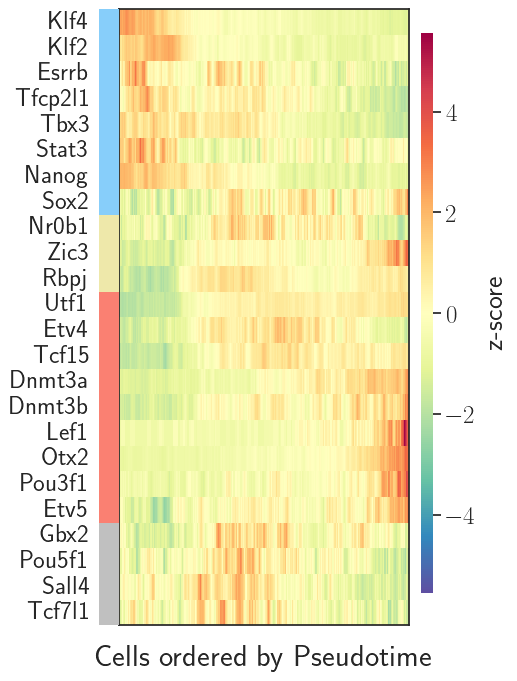

In [26]:
data_zscore = zscore(df_lN_mb_pst, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 8), 
                        gridspec_kw={'width_ratios': [1]}, 
                        sharey=True)

vmin = -max(abs(data_zscore).max())
vmax = max(abs(data_zscore).max())
cmap = 'Spectral_r'

sns.heatmap(data_zscore, ax=ax, cmap=cmap, yticklabels=df_lN_mb_pst.index,
            vmin=vmin, vmax=vmax)
ax.set_title('', fontsize=22)
ax.set_xticks(np.arange(len(hours_2iL)) + 1)  
ax.set_xticklabels([])
ax.tick_params(labelsize=18)

ax.collections[0].colorbar.remove()

cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, label='z-score')
cbar.ax.yaxis.label.set_fontsize(20)
cbar.ax.tick_params(labelsize=18)

cbar.outline.set_visible(False)

ax.set_ylabel('')

ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)

genes_relevant = df_lN_mb_pst.index.tolist()
colors = {
    'naive': 'lightskyblue',
    'formative_early': 'palegoldenrod',
    'formative_late': 'salmon',
    'other': 'silver'  
}

groups = {
    'naive': naive,
    'formative_early': formative_early,
    'formative_late': formative_late,
    'other': other  
}


divider = make_axes_locatable(ax)
line_ax = divider.append_axes("left", size=0.2, pad=0, sharey=ax)

line_ax.set_xlim(0, 1)
line_ax.set_ylim(ax.get_ylim())
line_ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
line_ax.spines['left'].set_visible(False)
line_ax.spines['right'].set_visible(False)
line_ax.spines['top'].set_visible(False)
line_ax.spines['bottom'].set_visible(False)

for group, gene_list in groups.items():
    for gene in gene_list:
        gene_idx = genes_relevant.index(gene)
        line_ax.axhspan(gene_idx, gene_idx + 1, color=colors[group], linewidth=0)

ax.set_yticks(np.arange(len(genes_relevant))+0.5)
ax.set_yticklabels(genes_relevant, fontsize=18, ha='right', va='center')
ax.set_xlabel("Cells ordered by Pseudotime", fontsize=22)
ax.tick_params(axis='y', pad=15)

# fig.savefig(os.path.join(fig_folder_path, 'heatmap_scRNAseq_pst_mb.svg'), format='svg', bbox_inches='tight')



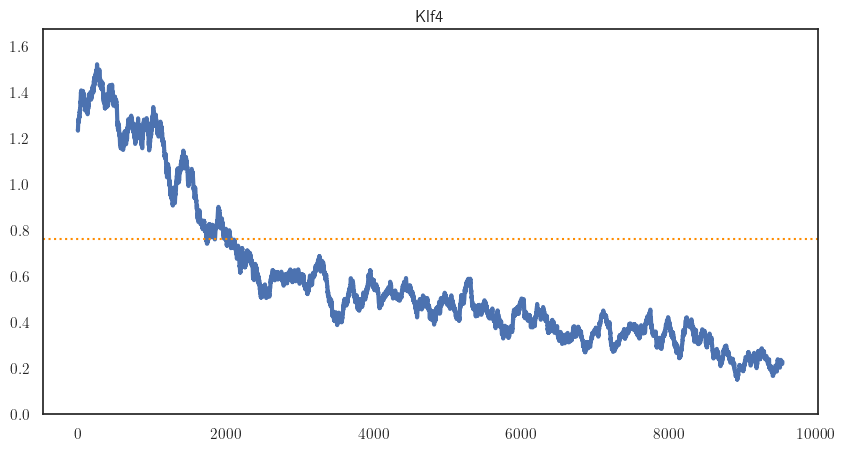

Klf4 0.7608401755889836


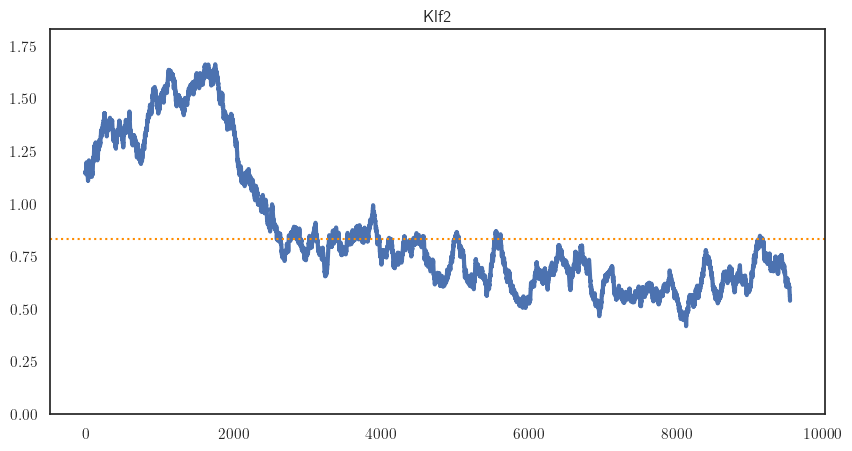

Klf2 0.8308052895422959


In [27]:
# Set the Flag to save or not the Figures showing the Gene Expression in time (with Mini-Bulk)
saving_fig=False
showing=True
count=0
if showing:
    # save the maximum value of each gene
    df_max = np.array(df_lN_mb_pst.max(axis=1))
    for ii in range(len(genes_relevant[:2])):
        plt.figure(figsize=(10,5))     
        plt.plot(np.linspace(0, len(df_lN_mb_pst.iloc[ii,:]), len(df_lN_mb_pst.iloc[ii,:])), df_lN_mb_pst.iloc[ii,:], lw=3)
        plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
        plt.title(genes_relevant[ii])
        plt.ylim(0, df_max[ii]+0.1*df_max[ii])
        if saving_fig==True:
            plt.savefig(path_data+"plot/halfmax_50/"+str(ii)+str(genes_relevant[ii])+"_gene.pdf")
        plt.show()
        print(genes_relevant[ii],df_max[ii]/2)
    count+=1

# Binarization (Half-max)

## LogNorm PST MB

In [31]:
fig_folder_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG/'

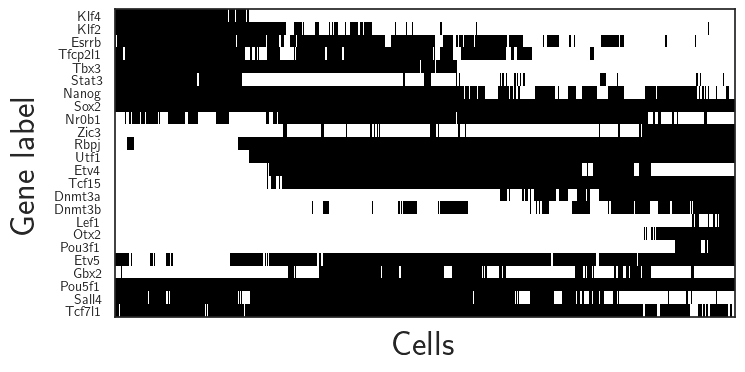

In [42]:
spins_df_lN_mb_pst = funcs_general.binnarization(df_lN_mb_pst, thr=thr)
fig, ax = plt.subplots(figsize=(8, 4))
fun_plot.raster_plot(np.array(spins_df_lN_mb_pst), ax,"", 1, genes_relevant)
# plt.savefig(fig_folder_path+' raster_plot_scRNAseq_logNorm_PST_MB.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()

# to save
if saving: 
    pd.DataFrame.to_csv(spins_df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv")


# Randomization

In [44]:
Ntest = 50

## LogNorm PST MB

In [46]:
N_rows = spins_df_lN_mb_pst.shape[0]
N_cols = spins_df_lN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_mb_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_lN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_lN_mb_pst_shuffle[ii,:,:] = trial_long
    
# to save
if saving: 
    np.save(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy", spins_df_lN_mb_pst_shuffle)


In [47]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))

    # zero expected if everything is working fine

0.0


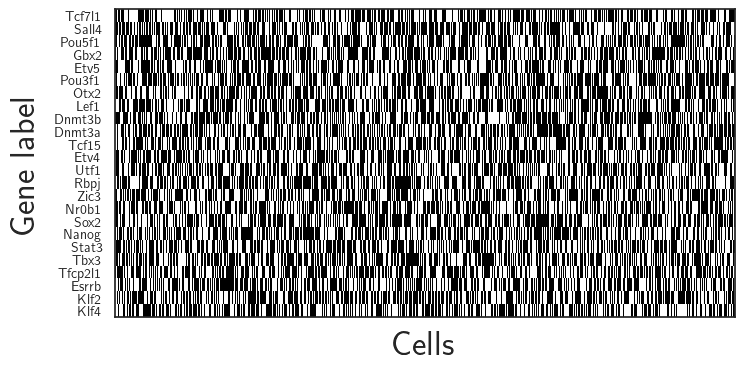

In [54]:
show_fig = True
if show_fig:
    for ii in range(0, Ntest, 50):
        fig, ax = plt.subplots(figsize=(8, 4))
        
        fun_plot.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]),ax, '', 1, genes_relevant[::-1])
        plt.show() 

